# Naive Bayes classifier for Fake News recognition
Fake news are defined by the New York Times as *"a made-up story with an intention to deceive"*, with
the intent to confuse or deceive people. They are everywhere in our daily life, and come especially from
social media platforms and applications in the online world. Being able to distinguish fake contents form
real news is today one of the most serious challenges facing the news industry.  

[Naive Bayes classifiers][1] are powerful algorithms that are used for text data analysis and are connected
to classification tasks of text in multiple classes.  
The goal of the project is to implement a __Multinomial Naive Bayes classifier__ in `R` and test its perfor-
mances in the classification of social media posts.
The suggested data set is available on [Kaggle][2]

[1]: https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf "C. D. Manning, Chapter 13, Text Classification and Naive Bayes, in Introduction to Information Retrieval, Cambridge University Press, 2008."
[2]: https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv

## Import useful libraries

In [1]:
library(tidyverse)
library(evaluate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Import dataset

In [2]:
df <- read_csv('NaiveBayesMNC/train_corrected2.csv', col_types = 'icc')
head(df, 10)

label_dict <- c('True', 'Not-Known', 'Mostly-True', 'Half-True', 'False', 'Barely-True')
names(label_dict) <- c('5', '4', '3', '2', '1', '0')

Labels,Text,Text_Tag
<int>,<chr>,<chr>
1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
2,The economic turnaround started at the end of my term.,"economy,jobs"
5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education
0,Jim Dunnam has not lived in the district he represents for years now.,candidates-biography
2,"I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate.",ethics
2,"However, it took $19.5 million in Oregon Lottery funds for the Port of Newport to eventually land the new NOAA Marine Operations Center-Pacific.",jobs


## Multinomial NB classifier implementation

In [5]:
confusion_matrix <- function( predictions, true_labels) {
    confusion_matrix <- matrix(rep(0, length(unique(true_labels))^2), ncol=length(unique(true_labels)))
    colnames(confusion_matrix) <- paste('t', label_dict, sep='_')
    rownames(confusion_matrix) <- paste('p', label_dict, sep='_')

    for(j in 1:ncol(confusion_matrix)) {
        for( i in 1:nrow(confusion_matrix)){
            confusion_matrix[i,j] <- sum(predictions==names(label_dict)[i] & true_labels==names(label_dict)[j])
        }    
    }

    return(confusion_matrix/length(predictions))
}

In [6]:
accuracy <- function(predictions, true_labels) {
    predictions <- as.numeric(predictions)
    true_labels <- as.numeric(true_labels)
    sum(predictions==true_labels) / length(predictions)
}

In [7]:
extract_vocabulary <- function(documents, unique=TRUE) {
    words <- str_replace_all(documents, "[:punct:]|[$]|[+]|[\u0090]", " ")
    words <- unlist(str_split(words, '[ ]|[\n]|[\t]'))
    words <- words[words!='']
    words <- casefold(words, upper = FALSE)
    words <- str_replace(words, "[:digit:]+", "isnumeric")
    if(unique) return(unique(words))
    else return(words)
}

In [8]:
extract_alnum <- function(documents, unique=TRUE, filter_n=0, freq_n = 0) {
    words <- str_replace_all(documents, "[:digit:]+[.,]*[:digit:]*", "isnumeric")
    words <- unlist(str_extract_all(words, "[:alnum:]+"))
    words <- words[words!='']
    words <- casefold(words, upper = FALSE)
    words <- words[!is.na(words)]
    if(filter_n){
        words <- words[nchar(words)>filter_n]
    }

    if(freq_n){
        freq <- table(words)
        words <- names(freq)[freq<freq_n]
    }

    if(unique) return(unique(words))
    else return(words)

}

In [ ]:
c <- extract_alnum(df[1,2],filter_n=0, freq_n=1)
cc <- extract_alnum(df[1,2])
c

character(0)

In [ ]:
multinomNBC.fit <- function(documents, labels, filter_n=0, freq_n=0) {
    # documents must be a list
    
    log.like  <- list()

    # extract vocabulary
    V <- extract_alnum(documents[[1]],filter_n = filter_n, freq_n = freq_n)
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)

    for(l in unique(labels[[1]])) {
        
        text <- extract_alnum(documents[labels==l], unique=FALSE)
        freq <- table(c(text, V))
        log.like[[as.character(l)]] <- log(freq) - log(sum(freq))
    }

    return(list(log.likelihood=log.like, log.prior=log.prior, vocabulary=V[order(V)]))
}

In [ ]:
multinomNBC.predict <- function(doc, log.prior, log.likelihood, voc){

    text <- extract_alnum(doc, unique=FALSE)
    freq <- table(text)[voc]
    freq <- freq[!is.na(freq)]
    #print(freq)
    scores <- rep(0, length(log.prior))
    names(scores) <- dimnames(log.prior)$Labels

    for( l in names(scores)) {
        scores[l] <- log.prior[l] + sum(log.likelihood[[l]][dimnames(freq)$text] * freq)
    }
    
    return(names(scores)[which.max(scores)])
    # return(scores)
}

multinomNBC.predict <- Vectorize(multinomNBC.predict, vectorize.args='doc', USE.NAMES=FALSE)

In [ ]:
nDoc <- dim(df)[1]

results <- multinomNBC.fit(df[1:nDoc, 2], df[1:nDoc, 1])
results$log.likelihood['1']

$`1`

                      a                      aa                     aaa 
              -4.227447              -10.035590              -10.035590 
                  aaron                    aarp                     aba 
             -10.035590              -10.035590              -10.728737 
              abandoned              abandoning                   abbas 
             -10.728737              -10.035590              -10.728737 
                 abbott                     abc                   abdul 
              -9.630125              -10.728737              -10.728737 
                 abedin                   abele                   abide 
             -10.035590               -9.119299              -10.035590 
                abiding               abilities                 ability 
             -10.728737              -10.035590               -8.936978 
                  abill                abillion                  abject 
             -10.728737              -10.0355

In [ ]:
pred <- Vectorize(multinomNBC.predict, vectorize.args='doc', USE.NAMES=FALSE)(df[1:1000, 2][[1]], results$log.prior, results$log.likelihood, results$vocabulary)

accuracy(pred, df[1:1000, 1][[1]])

[1] 0.638

In [ ]:
# for(i in seq_along(df$Text)) {
#     if(str_detect(df$Text[i], 'NA')) {
#         cat(df$Text[i], '\n')
#         cat(label_dict[as.character(df$Labels[i])], '\n\n')
#     }
# }

In [ ]:
#our vocabulary
voc <- extract_alnum(df[, 2][[1]], unique=TRUE)
# which(is.na(voc))
length(voc)
sum(is.na(voc))


[1] 11624

[1] 0

## Feature reduction

### Prediction sul training set 

In [ ]:
nDoc <- dim(df)[1]
results_red <- multinomNBC.fit(df[1:nDoc, 2], df[1:nDoc, 1], filter_n = 2)
results_red$log.prior

Labels
        0         1         2         3         4         5 
-1.824121 -1.636983 -1.576299 -1.653129 -2.501105 -1.808552 

In [ ]:
pred_red <- Vectorize(multinomNBC.predict, vectorize.args='doc', USE.NAMES=FALSE)(df[1:1000, 2][[1]], results_red$log.prior, results_red$log.likelihood, results_red$vocabulary)
accuracy(pred_red, df[1:1000, 1][[1]])

[1] 0.644

In [ ]:
confusion_matrix(pred_red, df[1:1000, 1][[1]])

,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.096,0.006,0.005,0.011,0.014,0.007
p_Not-Known,0.000,0.036,0.000,0.000,0.000,0.001
p_Mostly-True,0.022,0.011,0.150,0.029,0.027,0.026
p_Half-True,0.027,0.013,0.022,0.146,0.026,0.016
p_False,0.013,0.007,0.013,0.013,0.130,0.010
p_Barely-True,0.006,0.007,0.007,0.011,0.006,0.086


### Prediction sul test set 

In [ ]:
nDoc <- dim(df)[1]
results_test <- multinomNBC.fit(df[1:(nDoc-500), 2], df[1:(nDoc-500), 1], filter_n = 5)

pred_test <- Vectorize(multinomNBC.predict, vectorize.args='doc', USE.NAMES=FALSE)(df[(nDoc+1-500):nDoc, 2][[1]], results_test$log.prior, results_test$log.likelihood, results_test$vocabulary)
accuracy(pred_test, df[(nDoc+1-500):nDoc, 1][[1]])

[1] 0.246

In [ ]:
confusion_matrix(pred_test, df[(nDoc-500):nDoc, 1][[1]])

Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(label_dict)[i] & true_labels == names(label_dict)[j]:
“longer object length is not a multiple of shorter object length”
Warning message in predictions == names(

,t_True,t_Not-Known,t_Mostly-True,t_Half-True,t_False,t_Barely-True
p_True,0.012,0.010,0.024,0.022,0.034,0.026
p_Not-Known,0.018,0.012,0.006,0.010,0.012,0.004
p_Mostly-True,0.032,0.026,0.046,0.044,0.024,0.032
p_Half-True,0.050,0.018,0.032,0.068,0.072,0.038
p_False,0.040,0.012,0.040,0.040,0.026,0.032
p_Barely-True,0.022,0.016,0.036,0.030,0.018,0.018


file corrotti che sono stati sistemati sono dal 1282 al 12..

### Avoid Overfitting

In [ ]:
test <- 1000

results_freq <- multinomNBC.fit(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], filter_n = 2, freq_n = 60)

pred_freq <- multinomNBC.predict(df[(nDoc-test+1):nDoc, 2][[1]], results_freq$log.prior, results_freq$log.likelihood, results_freq$vocabulary)
accuracy(pred_freq, df[(nDoc-test+1):nDoc, 1][[1]])

[1] 0.217

# Building&nbsp;mutual&nbsp;information

In [ ]:
mutual_information <- function(N11,N10,N01,N00){
    N   <- N11 + N10 + N01 + N00
    N1  <- N11 + N10
    N.1 <- N11 + N01
    N0  <- N00 + N01
    N.0 <- N00 + N10

    # MI  <- N11/N * (log2(N)+log2(N11) -log2(N1)-log2(N.1)) + N01/N * log2(N*N01/(N0*N.1)) #+ N10/N * log2(N*N10/(N1*N.0)) + N00/N * log2(N*N00/(N0*N.0))
    MI  <- N11/N * (log2(N)+log2(N11) - log2(N1)- log2(N.1)) + N01/N * (log2(N)+log2(N01) - log2(N0)-log2(N.1)) + N10/N * (log2(N)+log2(N10) - log2(N1)- log2(N.0)) + N00/N * (log2(N)+log2(N00) - log2(N0)- log2(N.0))
    return(MI)
}

In [ ]:
words <- extract_alnum(df[df$Labels==0,2][[1]],unique=FALSE)
frase1 <- "Ciao sono Pietro e ho 23 anni"
frase1 <- casefold(frase1, upper = FALSE)

frasi <- c("ciao sono Pietro","Pietro mi chiamo","non mi chiamo Alberto")
frasi <- casefold(frasi, upper=FALSE)
grepl("pietro",frasi)

[1]  TRUE  TRUE FALSE

In [ ]:
N_11 <- c("w0","w1","w2","w3","w4","w5")
N_10 <- c("wnot0","wnot1","wnot2","wnot3","wnot4","wnot5")
N_01 <- c("notw0","notw1","notw2","notw3","notw4","notw5")
N_00 <- c("notwnot0","notwnot1","notwnot2","notwnot3","notwnot4","notwnot5")

col  <- c(sort(unique(df$Labels)), N_10, N_01, N_00)


In [ ]:
voc <- extract_alnum(df[, 2][[1]], unique=TRUE)

words_df <- data.frame(matrix(nrow=length(voc[1:500]),ncol=(length(col))),row.names=voc[1:500])
colnames(words_df) <- col

for (word in voc[1:500]){
    for (l in unique(df$Labels)){
        #aggiungo al elemento [word,l] il numero di documenti con label l che contengono word
        words_df[word,as.character(l)] <- sum(grepl(word,casefold(df$Text[df$Labels==l])))   #evaluate N_00
    }
    for (i in seq_along(N_10)){
        words_df[word,N_10[i]] <- sum(words_df[word,][-c(i,7:24)],na.rm=TRUE) #evaluate N_10
    }
}

In [ ]:
for (word in voc[1:500]){
    for (i in seq_along(N_10)){

        words_df[word,N_01[i]] <- sum(words_df[-which(row.names(words_df)==word),i],na.rm=TRUE) #evaluate N_01

        words_df[word,N_00[i]] <- sum(words_df[-which(row.names(words_df)==word),-c(i,7:24)],na.rm=TRUE) #evaluate N_00
        
    }
}

In [ ]:
# head(words_df,10)

In [ ]:
Labs <- sort(unique(df$Labels))
MI_df <- data.frame(matrix(nrow=length(voc[1:10]),ncol=(length(Labs))),row.names=voc[1:10])
colnames(MI_df) <- Labs

for (word in voc[1:500]){
    for (i in seq_along(Labs)){
        MI_df[word, i] <- mutual_information(words_df[word,i],words_df[word,i+6],words_df[word,i+12],words_df[word,i+18])
    }
}

#### Mutual information on all the vocabulary

In [ ]:
# FIRST WE BUILD WORDS_DF
voc <- extract_alnum(df[, 2][[1]], unique=TRUE)

words_df <- data.frame(matrix(nrow=length(voc),ncol=(length(col))),row.names=voc)
colnames(words_df) <- col

for (word in voc){
    for (l in unique(df$Labels)){
        #aggiungo al elemento [word,l] il numero di documenti con label l che contengono word
        words_df[word,as.character(l)] <- sum(grepl(word,casefold(df$Text[df$Labels==l])))   #evaluate N_00
    }
    for (i in seq_along(N_10)){
        words_df[word,N_10[i]] <- sum(words_df[word,][-c(i,7:24)],na.rm=TRUE) #evaluate N_10
    }
}
for (word in voc){
    for (i in seq_along(N_10)){

        words_df[word,N_01[i]] <- sum(words_df[-which(row.names(words_df)==word),i],na.rm=TRUE) #evaluate N_01

        words_df[word,N_00[i]] <- sum(words_df[-which(row.names(words_df)==word),-c(i,7:24)],na.rm=TRUE) #evaluate N_00
        
    }
}

# THEN WE BUILD THE MI DF

Labs <- sort(unique(df$Labels))
MI_df <- data.frame(matrix(nrow=length(voc),ncol=(length(Labs))),row.names=voc)
colnames(MI_df) <- Labs

for (word in voc){
    for (i in seq_along(Labs)){
        MI_df[word, i] <- mutual_information(words_df[word,i],words_df[word,i+6],words_df[word,i+12],words_df[word,i+18])
    }
}

In [ ]:
mi <- MI_df

# mi <- mi %>% mutate_if(.,apply(.,2,is.nan),0)
mi$'0'[is.nan(mi$'0')] <- 0
mi$'1'[is.nan(mi$'1')] <- 0
mi$'2'[is.nan(mi$'2')] <- 0
mi$'3'[is.nan(mi$'3')] <- 0
mi$'4'[is.nan(mi$'4')] <- 0
mi$'5'[is.nan(mi$'5')] <- 0

L <- as.character(Labs)
# for (i in L){
#     mi$i[is.nan(mi$i)] <- 0
# }
head(mi)

,0,1,2,3,4,5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
says,1.154849e-05,2.573665e-06,6.753102e-07,7.517013e-06,8.166449e-06,1.356008e-05
the,3.436961e-06,8.604335e-07,2.185836e-07,3.140522e-07,2.549261e-06,3.794525e-06
annies,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
list,7.623550e-07,9.159052e-07,1.208789e-06,4.505900e-06,9.750505e-06,3.731989e-07
political,1.606036e-06,9.896553e-07,2.387556e-08,3.422345e-07,1.326048e-06,1.707230e-07
group,5.375116e-06,7.795391e-07,1.571680e-06,7.759419e-06,8.465397e-06,5.037915e-06


### Extracting the MI vocaulary

In [ ]:
n <- 2000
mi_voc <- list()
mi_vocabulary <- vector()
for(i in L) {
    mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
    mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
}
length(mi_vocabulary)

[1] 6277

### Training with the Mutual information vocabulary

In [ ]:
multinomNBC.voc.fit <- function(documents, labels, voc) {
    # documents must be a list

    log.like  <- list()

    # extract vocabulary
    V <- voc
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)

    for(l in unique(labels[[1]])) {
        
        text <- extract_alnum(documents[labels==l], unique=FALSE)
        freq <- table(c(text, V))[V]
        log.like[[as.character(l)]] <- log(freq) - log(sum(freq))
    }

    return(list(log.likelihood=log.like, log.prior=log.prior, vocabulary=V[order(V)]))
}

In [ ]:
results_voc <- multinomNBC.voc.fit(df[1:nDoc, 2], df[1:nDoc, 1],voc=mi_vocabulary)
pred_voc <- multinomNBC.predict(df[1:1000, 2][[1]], results_voc$log.prior, results_voc$log.likelihood, results_voc$vocabulary)
accuracy(pred_voc, df[1:1000, 1][[1]])

[1] 0.585

In [ ]:
nDoc <- dim(df)[1]

# results_voc <- multinomNBC.fit(df[1:nDoc, 2], df[1:nDoc, 1])
# pred_voc <- multinomNBC.predict(df[1:1000, 2][[1]], results_voc$log.prior, results_voc$log.likelihood, mi_vocabulary)
# accuracy(pred_voc, df[1:1000, 1][[1]])

#### Test

In [ ]:
test <- 1000

voc_train <- multinomNBC.voc.fit(df[1:(nDoc-test), 2], df[1:(nDoc-test), 1], mi_vocabulary)

voc_pred  <- multinomNBC.predict(df[(nDoc-test+1):nDoc, 2][[1]], voc_train$log.prior, voc_train$log.likelihood, voc_train$vocabulary)

accuracy(voc_pred, df[(nDoc-test+1):nDoc, 1][[1]])

[1] 0.249

#### For the training set
Try different length of the MI vocabulary

In [ ]:
evaluate::inject_funs(
  flush.console = function() { base::flush.console(); evaluate::flush_console() },
  flush = function(con) { base::flush(con); evaluate::flush_console() }
)

n_perclass <- c(100,250,500,750,1000,1500,2000,2500,3000,4000,5000)
train_accuracy <- vector()

for (n in n_perclass){

    mi_voc <- list()
    mi_vocabulary <- vector()
    for(i in L) {
        mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
        mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
    }
    cat("The length of the vocabulary is",length(mi_vocabulary),"\n")
    
    results_voc <- multinomNBC.voc.fit(df[1:nDoc, 2], df[1:nDoc, 1],voc=mi_vocabulary)
    pred_voc <- multinomNBC.predict(df[1:nDoc, 2][[1]], results_voc$log.prior, results_voc$log.likelihood, results_voc$vocabulary)
    
    acc <- accuracy(pred_voc, df[1:nDoc, 1][[1]])
    train_accuracy <- append(train_accuracy, acc)
    
    cat("The accuracy for n =",n,"is",acc,"\n\n")
    flush_console()
}


The length of the vocabulary is 468 
The accuracy for n = 100 is 0.3289512 

The length of the vocabulary is 1176 
The accuracy for n = 250 is 0.4033499 

The length of the vocabulary is 2260 
The accuracy for n = 500 is 0.4728795 

The length of the vocabulary is 3178 
The accuracy for n = 750 is 0.5178693 

The length of the vocabulary is 4008 
The accuracy for n = 1000 is 0.5424092 

The length of the vocabulary is 5369 
The accuracy for n = 1500 is 0.5794138 

The length of the vocabulary is 6277 
The accuracy for n = 2000 is 0.5961632 

The length of the vocabulary is 6733 
The accuracy for n = 2500 is 0.6044405 

The length of the vocabulary is 7006 
The accuracy for n = 3000 is 0.606096 

The length of the vocabulary is 7168 
The accuracy for n = 4000 is 0.6054144 

The length of the vocabulary is 7483 
The accuracy for n = 5000 is 0.607362 



#### For the test set

In [ ]:
evaluate::inject_funs(
  flush.console = function() { base::flush.console(); evaluate::flush_console() },
  flush = function(con) { base::flush(con); evaluate::flush_console() }
)

test <- 2000

test_accuracy <- vector()

for (n in n_perclass){

    mi_voc <- list()
    mi_vocabulary <- vector()
    for(i in L) {
        mi_voc[[i]] <- rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n]
        mi_vocabulary <- union(mi_vocabulary, rownames(mi)[order(mi[,i], decreasing=TRUE)][1:n])
    }
    cat("The length of the vocabulary is",length(mi_vocabulary),"\n")
    
    voc_train <- multinomNBC.voc.fit(df[test:nDoc, 2], df[test:nDoc, 1], mi_vocabulary)
    voc_pred  <- multinomNBC.predict(df[1:test, 2][[1]], voc_train$log.prior, voc_train$log.likelihood, voc_train$vocabulary)
    
    acc <- accuracy(voc_pred, df[1:test, 1][[1]])
    test_accuracy <- append(test_accuracy, acc)
    
    cat("The accuracy for n =",n,"is",accuracy(voc_pred, df[1:test, 1][[1]]),"\n\n")
    flush_console()
}


The length of the vocabulary is 468 
The accuracy for n = 100 is 0.2745 

The length of the vocabulary is 1176 
The accuracy for n = 250 is 0.2865 

The length of the vocabulary is 2260 
The accuracy for n = 500 is 0.282 

The length of the vocabulary is 3178 
The accuracy for n = 750 is 0.281 

The length of the vocabulary is 4008 
The accuracy for n = 1000 is 0.273 

The length of the vocabulary is 5369 
The accuracy for n = 1500 is 0.2515 

The length of the vocabulary is 6277 
The accuracy for n = 2000 is 0.2365 

The length of the vocabulary is 6733 
The accuracy for n = 2500 is 0.2275 

The length of the vocabulary is 7006 
The accuracy for n = 3000 is 0.2235 

The length of the vocabulary is 7168 
The accuracy for n = 4000 is 0.2205 

The length of the vocabulary is 7483 
The accuracy for n = 5000 is 0.226 



Plot the accuracy on the training ad test set with respect to different length of mi vocabulary

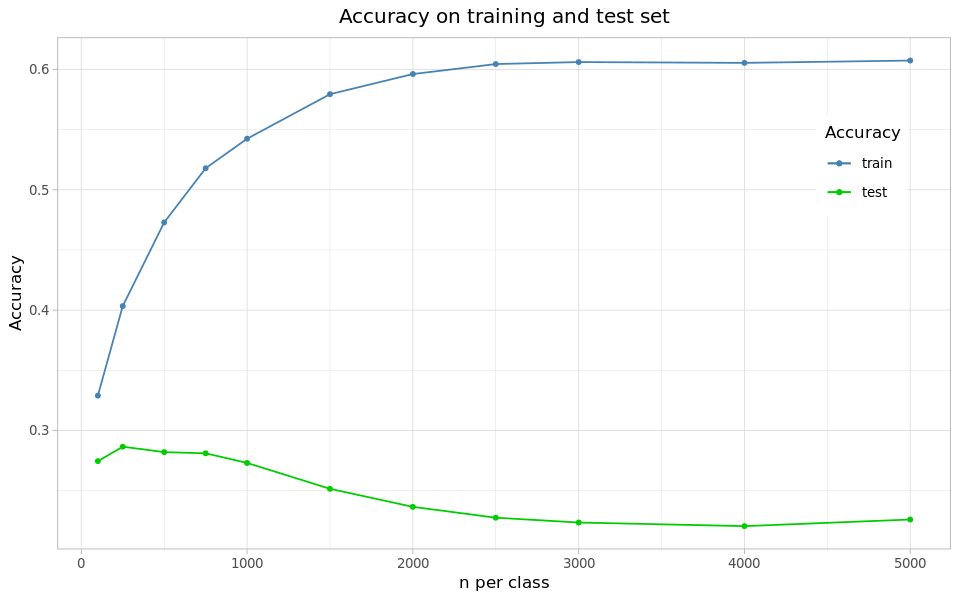

In [ ]:
acc_df <- data.frame(n_perclass, train_accuracy, test_accuracy)
options(repr.plot.width=8, repr.plot.height=5)
plot_acc <- ggplot(data=acc_df)+
            theme_light() +
            geom_line(aes(x=n_perclass, y=train_accuracy, color="train")) +
            geom_line(aes(x=n_perclass, y=test_accuracy,  color="test"))  +
            geom_point(aes(x=n_perclass, y=train_accuracy, color="train"),size=1) +
            geom_point(aes(x=n_perclass, y=test_accuracy,  color="test"),size=1) +
            labs(x="n per class", y="Accuracy", title="Accuracy on training and test set")+
            theme(plot.title = element_text(hjust = 0.5),text = element_text(size=10),legend.position=c(.9,.75))+
            scale_color_manual(name = "Accuracy", values = c("train" = "steelblue", "test" = "green3"))
plot_acc

ggsave("NaiveBayesMNC/Accuracy_plot.pdf",plot_acc,width = 10, height = 6)

## A fantastic plot

In [ ]:
freqs <- c(0, 10, 20, 30)#, 40, 50, 60, 70, 80, 90)
filters <- c(0, 1, 2, 3)#, 4, 5, 6, 7, 8, 9)
nDoc=dim(df)[1]
data <- matrix(ncol=length(freqs), nrow=length(filters))
rownames(data) <- filters
colnames(data) <- freqs
for(freq_n in freqs) {
    for(filter_n in filters) {
        results   <- multinomNBC.fit(df[1:nDoc, 2], df[1:nDoc, 1], filter_n = filter_n, freq_n = freq_n)
        pred <- multinomNBC.predict(df[1:nDoc, 2][[1]], results$log.prior, results$log.likelihood, results$vocabulary)
        data[as.character(filter_n), as.character(freq_n)] <- accuracy(pred, df[1:nDoc, 1][[1]])
    }
}

In [ ]:
# df_plt <- as.data.frame(data) %>% mutate(., filters=rownames(.)) %>% pivot_longer(., cols=colnames(.)[colnames(.)!='filters'], names_to='freqs', values_to='acc')
# df_plt

In [ ]:
# ggplot(df_plt, aes(x=filters, y=freqs)) +
# geom_raster(aes(fill=acc))

## Probability conditioned to tags

In [12]:
f_log.like.w_tc <- function(documents_l, tags_l, unique_tags, V, ...) {
    log.like.w_tc <- vector(mode='numeric', length=length(unique_tags))
    names(log.like.w_tc) <- unique_tags
    tag_mask <- Vectorize(grepl, 'pattern')(unique_tags, tags_l)
    
    log.like.w_tc <- Vectorize(function(t) {
            text <- extract_alnum(documents_l[tag_mask[,t]], unique=FALSE, ...)
            freq <- table(c(text, V))
            log(freq) - log(sum(freq))
        }, 't')(unique_tags)
        
    return(log.like.w_tc)
}

multinomNBC_t.fit <- function(documents, labels, tags, ...) {
  
    # extract vocabulary, tags, and labels
    V <- extract_alnum(documents[[1]], ...)
    all_tags <- str_extract_all(tags[[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')
    unique_tags <- unique(unlist(all_tags))
    unique_labels <- unique(labels[[1]])

    #prior
    N <- length(documents[[1]])
    log.prior <- log(table(labels)) - log(N)
    #likelihood of word given tag and class
    dimnames.w_tc <- list(unique_labels, unique_tags, V)
    log.like.w_tc <- array(dim=c(length(unique_labels), length(unique_tags), length(V)), dimnames=dimnames.w_tc)
    #likelihood of tag given class
    dimnames.t_c <- list(unique_labels, unique_tags)
    log.like.t_c <- matrix(nrow=length(unique_labels), ncol=length(unique_tags), dimnames=dimnames.t_c)

    for(l in unique_labels) {
        
        tags_l <- all_tags[labels==l]
        tag_freq <- table(c(unlist(tags_l), unique_tags))
        log.like.t_c[as.character(l), ] <- log(tag_freq) - log(sum(tag_freq))

        log.like.w_tc[as.character(l), , ] <- t(f_log.like.w_tc(documents[labels==l], tags_l, unique_tags, V, ...))
    }

    return(list(log.likelihood.w_tc=log.like.w_tc, log.likelihood.t_c=log.like.t_c, log.prior=log.prior, vocabulary=V[order(V)], tags=unique_tags))
}

multinomNBC_t.predict <- function(doc, tag, log.prior, log.likelihood.w_tc, log.likelihood.t_c, voc){

    text <- extract_alnum(doc, unique=FALSE)
    freq <- table(text)[voc]
    freq <- freq[!is.na(freq)]
    
    scores <- rep(0, length(log.prior))
    names(scores) <- dimnames(log.prior)$Labels
    
    for( l in names(scores)) {
        scores[l] <- log.prior[l] + sum(log.likelihood.w_tc[l, tag, dimnames(freq)$text] * freq) + log.likelihood.t_c[l, tag]
    }
    
    return(names(scores)[which.max(scores)[[1]]])
}

multinomNBC_t.predict <- Vectorize(multinomNBC_t.predict, vectorize.args=c('doc', 'tag'), USE.NAMES=FALSE)

In [13]:
results <- multinomNBC_t.fit(df[1:1000, 2], df[1:1000, 1], df[1:1000, 3])
results

$log.likelihood.w_tc
, , says

   abortion    energy   history job-accomplishments foreign-policy health-care
1 -7.529675 -8.207674 -6.636734           -7.513164      -6.836796   -7.218177
2 -8.193677 -8.223895 -6.837601           -7.545125      -6.626718   -6.186723
3 -7.509335 -7.501911 -6.053396           -7.127694      -6.293155   -7.152530
5 -7.511798 -6.826274 -6.825731           -8.219865      -7.115853   -7.119366
0 -7.104418 -6.420809 -7.512071           -7.513164      -6.283067   -6.001167
4 -7.499147 -7.521318 -6.292891           -8.208492      -8.213111   -6.853563
    economy      jobs education candidates-biography    ethics
1 -6.486161 -6.870313 -7.529943            -6.843750 -8.197814
2 -6.529175 -6.221335 -6.489458            -7.555644 -7.104144
3 -5.956308 -6.668736 -6.706618            -6.851714 -6.590850
5 -6.330739 -8.238273 -6.641965            -6.287062 -7.506042
0 -6.866673 -8.217708 -6.824645            -7.153312 -8.195334
4 -7.508513 -7.502738 -7.100577       

In [14]:
doc <- 10012
pred <- multinomNBC_t.predict(df[doc, 2][[1]], unlist(str_extract_all(df[doc, 3][[1]], '[:alnum:]+[-]?[:alnum:]*[-]?[:alnum:]*')), results$log.prior, results$log.likelihood.w_tc, results$log.likelihood.t_c, results$vocabulary)
cat('predictions\n', label_dict[as.character(pred)])
cat('\ntrue\n', label_dict[as.character(df[doc, 1][[1]])])

predictions
 True False Not-Known
true
 Mostly-True

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=811d2f44-4ec2-4c23-800a-72ed1acf812e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>